In [39]:
import os
import random
import math
from collections import defaultdict
from typing import List, Tuple, Dict


import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt


from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import ndcg_score
from scipy.stats import kendalltau, ttest_rel

# Set torch device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Device: cpu


In [93]:
# clip-ViT-B-32 →  (lightweight)

# clip-ViT-B-16 → slightly more precise

# clip-ViT-L-14 → large model, much better representation, especially for fine-grained tasks

CONFIG = {
"model_name": "clip-ViT-B-16",
"max_images": 1000, # set a cap for experiments; 100-1000 depending on RAM
"image_batch_size": 32, # smaller batch if low RAM
"text_batch_size": 64,
"top_k": 5,
}

In [ ]:
!pip install -q sentence-transformers datasets pillow matplotlib scikit-learn scipy

In [94]:
#load model
model = SentenceTransformer(CONFIG['model_name'])
model.to(DEVICE)
EMB_DIM = model.get_sentence_embedding_dimension()
print(f"Loaded {CONFIG['model_name']} with dim {EMB_DIM}")

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/354 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Loaded clip-ViT-B-16 with dim None


In [95]:
# download PathMNIST Dataset

import requests

PATHMNIST_URL = "https://zenodo.org/record/5208230/files/pathmnist.npz?download=1"
DATA_FN = "pathmnist.npz"


if not os.path.exists(DATA_FN):
  print("Downloading PathMNIST (this may take a minute)...")
  r = requests.get(PATHMNIST_URL, timeout=120)
  with open(DATA_FN, 'wb') as f:
    f.write(r.content)
  print("Downloaded.")


data = np.load(DATA_FN)

x_train = data['train_images']
y_train = data['train_labels'].reshape(-1)


label_names = [
"adipose",
"background",
"debris",
"lymphocytes",
"mucus",
"smooth_muscle",
"normal_colon_mucosa",
"cancer_associated_stroma",
"colorectal_adenocarcinoma"
]

print(f"Dataset shape: {x_train.shape}")
print(f"Labels: {label_names}")

Dataset shape: (89996, 28, 28, 3)
Labels: ['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth_muscle', 'normal_colon_mucosa', 'cancer_associated_stroma', 'colorectal_adenocarcinoma']


Using N=1000 images


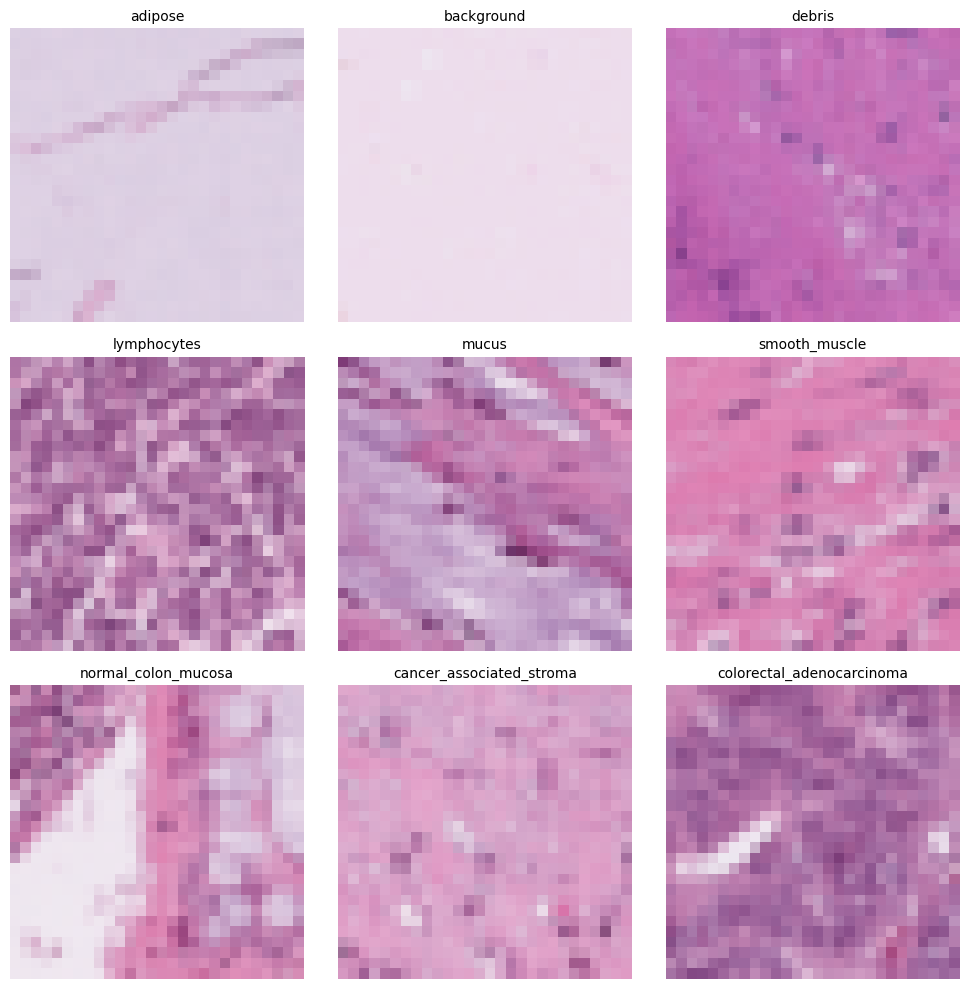

Saved sample images to 'sample_images.png'


In [96]:
# Visualize sample images from each class

N = min(CONFIG['max_images'], len(x_train))
images_np = x_train[:N]
labels = y_train[:N]
print(f"Using N={N} images")

# Show sample images from each class
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i, label_idx in enumerate(range(9)):
    # Find first image of this class
    idx = np.where(labels == label_idx)[0][0]
    img = images_np[idx]

    axes[i].imshow(img)
    axes[i].set_title(f"{label_names[label_idx]}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved sample images to 'sample_images.png'")

In [97]:
# Convert Images to PIL and Create Embeddings

pil_images = [Image.fromarray(img.astype(np.uint8)) for img in images_np]

def encode_images(images: List[Image.Image], batch_size: int = 32) -> torch.Tensor:
  all_embs = []
  for i in range(0, len(images), batch_size):
    batch = images[i:i+batch_size]
    embs = model.encode(batch, convert_to_tensor=True, show_progress_bar=False)
    all_embs.append(embs.cpu())
    # free memory
    del embs
    torch.cuda.empty_cache()
  return torch.cat(all_embs, dim=0)


image_embeddings = encode_images(pil_images, batch_size=CONFIG['image_batch_size'])
print("Image embeddings shape:", image_embeddings.shape)

Image embeddings shape: torch.Size([1000, 512])


In [98]:
# Define controlled prompt template families to test linguistic phenomena

PROMPT_TEMPLATES = {
'concise': [
"{label}",
],
'clinical': [
"Histology: {label}",
"Microscopic image showing {label}",
"H&E stained slide: {label}",
],
'descriptive': [
"Photomicrograph of {label} with hematoxylin and eosin staining",
"High-resolution histology of {label} tissue",
],
'with_modifier': [
"{label} -- tumor region",
"{label} with inflammatory cells",
"{label} (H&E)",
],
'disease_vs_normal': [
"normal {label}",
"abnormal {label}",
"tumor {label}",
]
}

# Controlled linguistic manipulations: synonyms, specificity levels, presence/absence of stain
SYNONYMS = {
'colorectal_adenocarcinoma': ['colorectal adenocarcinoma', 'colon adenocarcinoma', 'colonic adenocarcinoma', 'colon cancer'],
'normal_colon_mucosa': ['normal colon mucosa', 'healthy colon mucosa', 'normal colon tissue'],
'lymphocytes': ['lymphocytes', 'immune cells', 'lymphocytic infiltrate'],
}

# Build prompt bank
prompt_bank = []
prompt_map = [] # keep meta info per prompt


for i, lab_idx in enumerate(np.unique(labels)):
  lab_name = label_names[int(lab_idx)]
  # base synonyms
  syns = SYNONYMS.get(lab_name, [lab_name])

  for syn in syns:
    for fam, templates in PROMPT_TEMPLATES.items():
      for t in templates:
        text = t.format(label=syn)
        prompt_bank.append(text)
        prompt_map.append({
          'label_idx': int(lab_idx),
          'label_name': lab_name,
          'synonym': syn,
          'family': fam,
          'template': t,
          })

# Add some manual adversarial prompts / ambiguous prompts
adversarials = [
"tumor cells", "glandular structures", "mucosal tissue", "fat cells", "background noise",
]
for a in adversarials:
  prompt_bank.append(a)
  prompt_map.append({'label_idx': None, 'label_name': None, 'synonym': a, 'family': 'adversarial', 'template': a})


print(f"Generated {len(prompt_bank)} prompts across families")

print("\nExample prompts:")
for i in range(0, min(15, len(prompt_bank)), 3):
    print(f"  - {prompt_bank[i]}")



Generated 197 prompts across families

Example prompts:
  - adipose
  - H&E stained slide: adipose
  - adipose -- tumor region
  - normal adipose
  - background


In [99]:
# encode prompts

def encode_prompts(prompts: List[str], batch_size: int = 64) -> torch.Tensor:
  all_embs = []
  for i in range(0, len(prompts), batch_size):
    batch = prompts[i:i+batch_size]
    embs = model.encode(batch, convert_to_tensor=True, show_progress_bar=False)
    all_embs.append(embs.cpu())
  return torch.cat(all_embs, dim=0)


prompt_embeddings = encode_prompts(prompt_bank, batch_size=CONFIG['text_batch_size'])
print("Prompt embeddings shape:", prompt_embeddings.shape)

Prompt embeddings shape: torch.Size([197, 512])


In [118]:
# Retrieval & metrics

# cosine similarity

def cosine_sim(a: np.ndarray, b: np.ndarray) -> np.ndarray:
  # a: (m, d), b: (n, d) -> (m, n)
  a_norm = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-10)
  b_norm = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-10)
  return a_norm @ b_norm.T


# convert embeddings to numpy
img_emb_np = image_embeddings.numpy()
pr_emb_np = prompt_embeddings.numpy()


def retrieve_by_prompt(prompt_idx: int, top_k: int = 5) -> List[Tuple[int, float]]:
  sims = cosine_sim(pr_emb_np[prompt_idx:prompt_idx+1], img_emb_np)[0]
  topk_idx = np.argsort(-sims)[:top_k]
  return [(int(i), float(sims[i])) for i in topk_idx]


# evaluation metrics

def precision_at_k(retrieved_idxs: List[int], true_label: int, k: int) -> float:
  if k == 0:
    return 0.0
  hits = sum(1 for i in retrieved_idxs[:k] if labels[i] == true_label)
  return hits / k

def evaluate_prompt(prompt_idx: int, k: int = 5) -> Dict:
    meta = prompt_map[prompt_idx]
    retrieved = retrieve_by_prompt(prompt_idx, top_k=k)
    idxs = [r[0] for r in retrieved]

    if meta['label_idx'] is None:
        return {'precision@k': None, 'ap@k': None, 'retrieved': retrieved}

    true_label = meta['label_idx']
    p_at_k = precision_at_k(idxs, true_label, k)
    return {'precision@k': p_at_k, 'retrieved': retrieved}

# Test it with one prompt
test_prompt_idx = 0
test_result = evaluate_prompt(test_prompt_idx, k=5)
print(f"Test prompt: '{prompt_bank[test_prompt_idx]}'")
print(f"Precision@5: {test_result['precision@k']:.2f}")

test_prompt_idx = 1
test_result = evaluate_prompt(test_prompt_idx, k=5)
print(f"Test prompt: '{prompt_bank[test_prompt_idx]}'")
print(f"Precision@5: {test_result['precision@k']:.2f}")

test_prompt_idx = 19
test_result = evaluate_prompt(test_prompt_idx, k=5)
print(f"Test prompt: '{prompt_bank[test_prompt_idx]}'")
print(f"Precision@5: {test_result['precision@k']:.2f}")

Test prompt: 'adipose'
Precision@5: 0.60
Test prompt: 'Histology: adipose'
Precision@5: 0.00
Test prompt: 'background with inflammatory cells'
Precision@5: 0.00


In [120]:
# Evaluate All Prompts and Compare Families

K = CONFIG['top_k']
results = []
for i in range(len(prompt_bank)):
    res = evaluate_prompt(i, k=K)
    results.append(res)

# Aggregate by family
from statistics import mean

family_stats = defaultdict(list)
for i, r in enumerate(results):
    fam = prompt_map[i]['family']
    if r['precision@k'] is not None:
        family_stats[fam].append(r['precision@k'])

print(f"Per-family Precision@{K}:")
for fam in family_stats.keys():
    vals = family_stats[fam]
    print(f"  {fam:20s}: n={len(vals):3d}, mean P@{K} = {mean(vals):.3f}")


Per-family Precision@5:
  concise             : n= 16, mean P@5 = 0.338
  clinical            : n= 48, mean P@5 = 0.321
  descriptive         : n= 32, mean P@5 = 0.281
  with_modifier       : n= 48, mean P@5 = 0.308
  disease_vs_normal   : n= 48, mean P@5 = 0.308


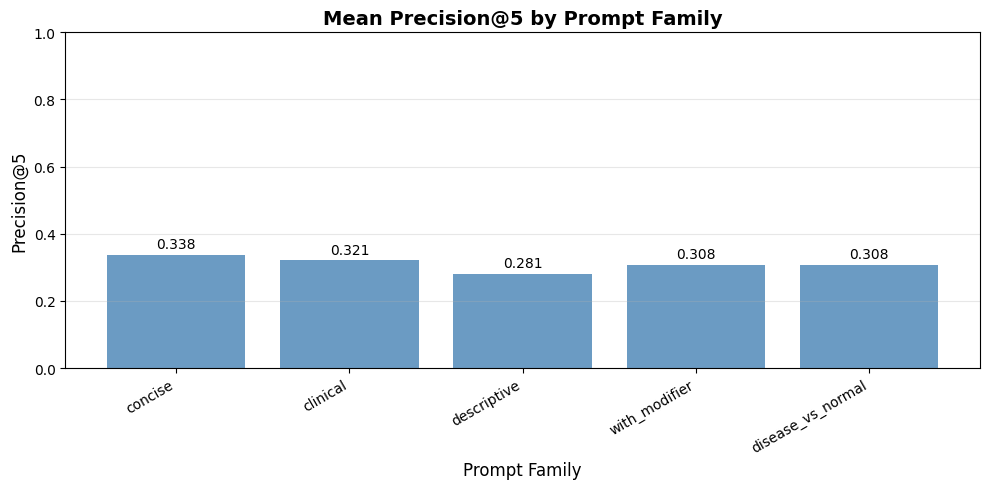

In [121]:
# Visualize Results by Family
def plot_family_precisions(family_stats: Dict[str, List[float]], k: int = 5):
    families = [f for f in family_stats.keys() if f != 'adversarial']
    means = [np.mean(family_stats[f]) for f in families]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(families, means, color='steelblue', alpha=0.8)
    plt.title(f"Mean Precision@{k} by Prompt Family", fontsize=14, fontweight='bold')
    plt.ylabel(f"Precision@{k}", fontsize=12)
    plt.xlabel("Prompt Family", fontsize=12)
    plt.xticks(rotation=30, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, mean_val in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{mean_val:.3f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('family_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_family_precisions(family_stats, k=K)

Comparing different phrasings for 'colorectal adenocarcinoma':



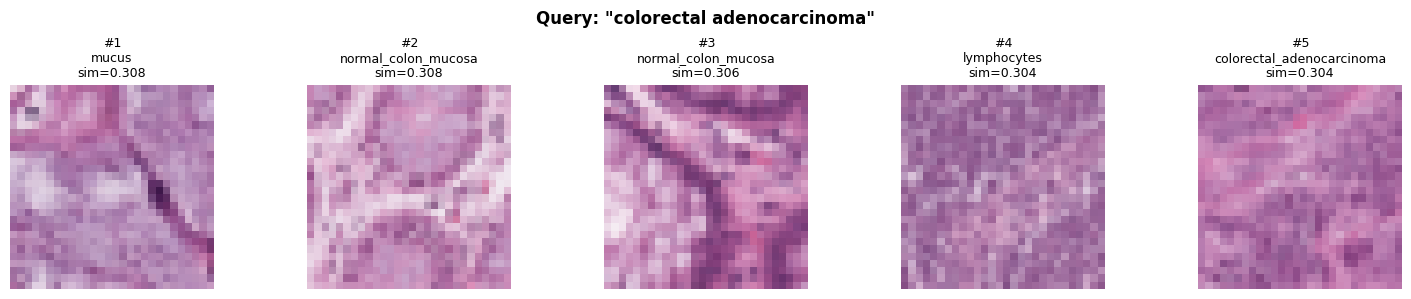

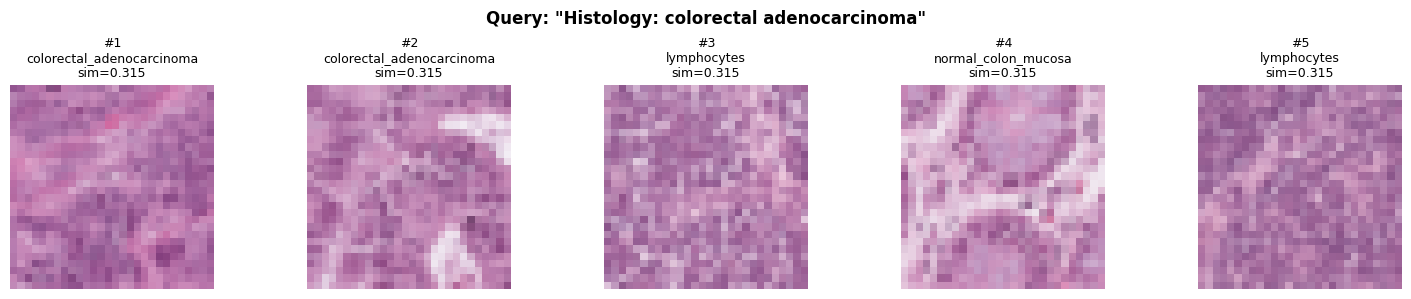

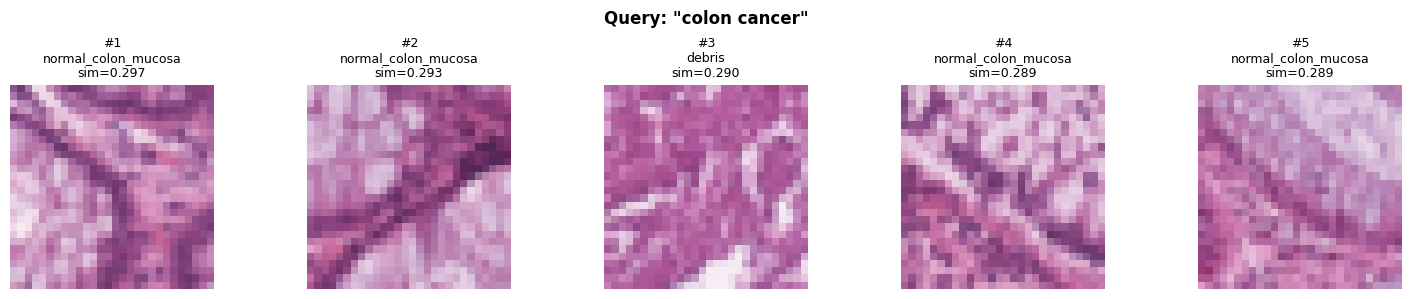

In [125]:
# Visualize Retrieved Images for Different Prompts
def visualize_retrieval(prompt_text: str, top_k: int = 5):
    # Find prompt index
    prompt_idx = prompt_bank.index(prompt_text)
    retrieved = retrieve_by_prompt(prompt_idx, top_k=top_k)

    fig, axes = plt.subplots(1, top_k, figsize=(15, 3))
    fig.suptitle(f'Query: "{prompt_text}"', fontsize=12, fontweight='bold')

    for i, (img_idx, score) in enumerate(retrieved):
        axes[i].imshow(images_np[img_idx])
        true_label = label_names[labels[img_idx]]
        axes[i].set_title(f'#{i+1}\n{true_label}\nsim={score:.3f}', fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Compare different phrasings
print("Comparing different phrasings for 'colorectal adenocarcinoma':\n")
test_prompts = [
    "colorectal adenocarcinoma",
    "Histology: colorectal adenocarcinoma",
    "colon cancer",
]

for prompt in test_prompts:
    if prompt in prompt_bank:
        visualize_retrieval(prompt, top_k=5)

In [126]:
# Prompt sensitivity: rank correlation between prompts

rank_lists = []
for i in range(len(prompt_bank)):
    sims = cosine_sim(pr_emb_np[i:i+1], img_emb_np)[0]
    rank = list(np.argsort(-sims))
    rank_lists.append(rank)

pairwise_tau = []
for i in range(len(prompt_bank)):
    for j in range(i+1, len(prompt_bank)):
        if prompt_map[i]['label_idx'] is None or prompt_map[j]['label_idx'] is None:
            continue
        if prompt_map[i]['label_idx'] != prompt_map[j]['label_idx']:
            continue

        M = min(200, img_emb_np.shape[0])
        rank_i = rank_lists[i][:M]
        rank_j = rank_lists[j][:M]
        inv_i = {v: idx for idx, v in enumerate(rank_i)}
        inv_j = {v: idx for idx, v in enumerate(rank_j)}

        common = list(set(rank_i) & set(rank_j))
        if len(common) < 10:
            continue

        arr_i = [inv_i[v] for v in common]
        arr_j = [inv_j[v] for v in common]
        tau, p = kendalltau(arr_i, arr_j)
        pairwise_tau.append({'i': i, 'j': j, 'tau': tau, 'p': p})

if pairwise_tau:
    taus = [x['tau'] for x in pairwise_tau if not math.isnan(x['tau'])]
    print(f"Mean Kendall tau among paraphrases: {np.mean(taus):.3f}")
    print(f"This measures ranking consistency between different phrasings of the same label.")
    print(f"1.0 = perfect agreement, 0 = random, -1 = opposite rankings")
else:
    print("No valid prompt pairs for comparison")

Mean Kendall tau among paraphrases: 0.287
This measures ranking consistency between different phrasings of the same label.
1.0 = perfect agreement, 0 = random, -1 = opposite rankings


In [127]:
concise_idxs = [i for i, m in enumerate(prompt_map) if m['family'] == 'concise']
clinical_idxs = [i for i, m in enumerate(prompt_map) if m['family'] == 'clinical']

paired = []
for ci in concise_idxs:
    for cli in clinical_idxs:
        if (prompt_map[ci]['label_idx'] == prompt_map[cli]['label_idx'] and
            prompt_map[ci]['label_idx'] is not None):
            p1 = results[ci]['precision@k']
            p2 = results[cli]['precision@k']
            if p1 is not None and p2 is not None:
                paired.append((p1, p2))

if paired:
    a = np.array([p[0] for p in paired])
    b = np.array([p[1] for p in paired])
    tstat, pval = ttest_rel(a, b)
    print(f"Paired t-test: concise vs clinical (n={len(paired)})")
    print(f"  t-statistic: {tstat:.3f}")
    print(f"  p-value: {pval:.3f}")
    print(f"  Mean difference: {np.mean(a - b):.3f}")

    if pval < 0.05:
        print("  → Statistically significant difference!")
    else:
        print("  → No significant difference")
else:
    print("No paired prompts found")

Paired t-test: concise vs clinical (n=120)
  t-statistic: -0.644
  p-value: 0.521
  Mean difference: -0.017
  → No significant difference


In [128]:
# Cell 14: Save Results
OUT_DIR = 'exp_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

np.save(os.path.join(OUT_DIR, 'image_embeddings.npy'), img_emb_np)
np.save(os.path.join(OUT_DIR, 'prompt_embeddings.npy'), pr_emb_np)

import json
with open(os.path.join(OUT_DIR, 'prompt_map.json'), 'w') as f:
    json.dump(prompt_map, f, indent=2)

# Save summary
summary = {
    'num_images': len(images_np),
    'num_prompts': len(prompt_bank),
    'top_k': K,
    'family_precision': {fam: float(np.mean(vals))
                        for fam, vals in family_stats.items()},
}

with open(os.path.join(OUT_DIR, 'summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved embeddings and results to '{OUT_DIR}/'")
print(f"✓ Files created:")
print(f"  - image_embeddings.npy (image vectors)")
print(f"  - prompt_embeddings.npy (text vectors)")
print(f"  - prompt_map.json (prompt metadata)")
print(f"  - summary.json (results summary)")

✓ Saved embeddings and results to 'exp_outputs/'
✓ Files created:
  - image_embeddings.npy (image vectors)
  - prompt_embeddings.npy (text vectors)
  - prompt_map.json (prompt metadata)
  - summary.json (results summary)
